### This dataset contains historic data for a variety of Japanese stocks and options. Your challenge is to predict the future returns of the stocks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
TeslaData = pd.read_csv("/content/Tesla.csv ")

In [ ]:
TeslaData.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [ ]:
TeslaData["Close"].value_counts()

27.420000     4
31.490000     3
26.500000     3
20.540001     3
27.120001     3
             ..
46.970001     1
45.450001     1
45.590000     1
43.299999     1
261.500000    1
Name: Close, Length: 1528, dtype: int64

<Axes: >

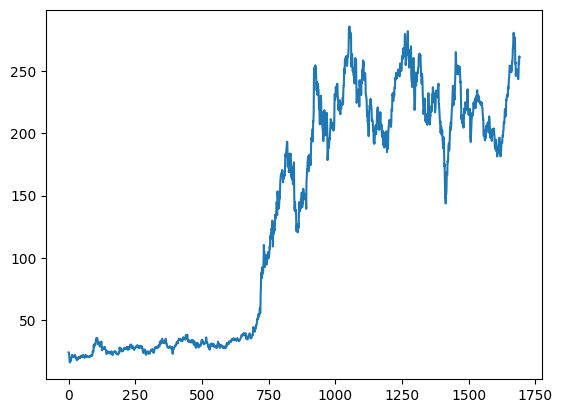

In [ ]:
TeslaData["Close"].plot()

In [ ]:
data = TeslaData[["Date", "Close"]]
data

,Date,Close
0,6/29/2010,23.889999
1,6/30/2010,23.830000
2,7/1/2010,21.959999
3,7/2/2010,19.200001
4,7/6/2010,16.110001
...,...,...
1687,3/13/2017,246.169998
1688,3/14/2017,258.000000
1689,3/15/2017,255.729996
1690,3/16/2017,262.049988


In [ ]:
data["Date"]

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
1687   2017-03-13
1688   2017-03-14
1689   2017-03-15
1690   2017-03-16
1691   2017-03-17
Name: Date, Length: 1692, dtype: datetime64[ns]

In [ ]:
data["Date"] = pd.to_datetime(data["Date"], format= '%m/%d/%Y')

<ipython-input-16-e85e5a15b8e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = pd.to_datetime(data["Date"], format= '%m/%d/%Y')


In [ ]:
data.set_index('Date', inplace=True)

In [ ]:
data.head(50)

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
2010-07-07,15.800000
2010-07-08,17.459999
2010-07-09,17.400000
2010-07-12,17.049999


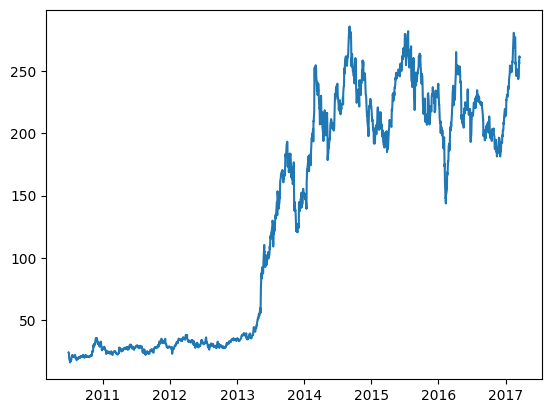

In [ ]:
plt.plot(data.index, data['Close'])

In [ ]:
def str_to_datetime(date_str):
    return datetime.datetime.strptime(date_str, '%Y-%m-%d')


In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(data,
                                '2010-09-08',
                                '2017-03-17',
                                n=49)
windowed_df

,Target Date,Target-49,Target-48,Target-47,Target-46,Target-45,Target-44,Target-43,Target-42,Target-41,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2010-09-08,23.889999,23.830000,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,...,19.900000,19.750000,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000
1,2010-09-09,23.830000,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,...,19.750000,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999
2,2010-09-10,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,...,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000
3,2010-09-13,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,19.889999,...,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000,20.719999
4,2010-09-14,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,19.889999,20.639999,...,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000,20.719999,21.120001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2017-03-13,214.679993,213.690002,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,...,249.990005,250.020004,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998
1639,2017-03-14,213.690002,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,...,250.020004,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000
1640,2017-03-15,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,237.750000,...,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000,255.729996
1641,2017-03-16,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,237.750000,235.580002,...,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000,255.729996,262.049988


In [ ]:
windowed_df

,Target Date,Target-49,Target-48,Target-47,Target-46,Target-45,Target-44,Target-43,Target-42,Target-41,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2010-09-08,23.889999,23.830000,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,...,19.900000,19.750000,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000
1,2010-09-09,23.830000,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,...,19.750000,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999
2,2010-09-10,21.959999,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,...,19.700001,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000
3,2010-09-13,19.200001,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,19.889999,...,19.870001,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000,20.719999
4,2010-09-14,16.110001,15.800000,17.459999,17.400000,17.049999,18.139999,19.840000,19.889999,20.639999,...,19.480000,20.450001,21.059999,21.049999,20.540001,20.900000,20.709999,20.170000,20.719999,21.120001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2017-03-13,214.679993,213.690002,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,...,249.990005,250.020004,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998
1639,2017-03-14,213.690002,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,...,250.020004,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000
1640,2017-03-15,216.990005,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,237.750000,...,250.479996,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000,255.729996
1641,2017-03-16,226.990005,226.750000,229.009995,231.279999,229.869995,229.729996,229.589996,237.750000,235.580002,...,251.570007,251.210007,248.589996,246.869995,244.899994,243.690002,246.169998,258.000000,255.729996,262.049988


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1643,), (1643, 49, 1), (1643,))

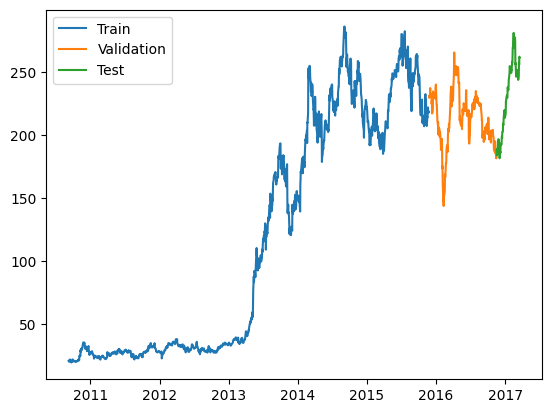

In [ ]:
q_80 = int(len(dates) * .8)
q_95 = int(len(dates) * .95)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_95], X[q_80:q_95], y[q_80:q_95]
dates_test, X_test, y_test = dates[q_95:], X[q_95:], y[q_95:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model = Sequential([
    layers.Input((49,1)),
    layers.LSTM(64),
    layers.Dense(32 , activation = "relu"),
    layers.Dense(32 , activation = "relu"),
    layers.Dense(1)
])

model.compile(loss = "mse", optimizer = Adam(learning_rate=0.001), metrics = ["mean_absolute_error"])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

Epoch 1/100
42/42 [==============================] - 6s 46ms/step - loss: 21703.3555 - mean_absolute_error: 113.6646 - val_loss: 44787.2266 - val_mean_absolute_error: 210.5340
Epoch 2/100
42/42 [==============================] - 1s 31ms/step - loss: 19601.6660 - mean_absolute_error: 101.5640 - val_loss: 34832.6836 - val_mean_absolute_error: 185.3771
Epoch 3/100
42/42 [==============================] - 2s 36ms/step - loss: 11752.4258 - mean_absolute_error: 85.9339 - val_loss: 12268.6807 - val_mean_absolute_error: 108.6727
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 4196.6094 - mean_absolute_error: 54.5328 - val_loss: 1395.1757 - val_mean_absolute_error: 33.3915
Epoch 5/100
42/42 [==============================] - 2s 42ms/step - loss: 376.8051 - mean_absolute_error: 11.5386 - val_loss: 136.9917 - val_mean_absolute_error: 8.8319
Epoch 6/100
42/42 [==============================] - 1s 31ms/step - loss: 88.5990 - mean_absolute_error: 5.4553 - val_loss: 72.1621 

In [ ]:
len(dates_train)

1314

In [ ]:
len(X_train)

1314

Exception ignored in: <function _xla_gc_callback at 0x7b6bd2af5fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


42/42 [==============================] - 1s 11ms/step


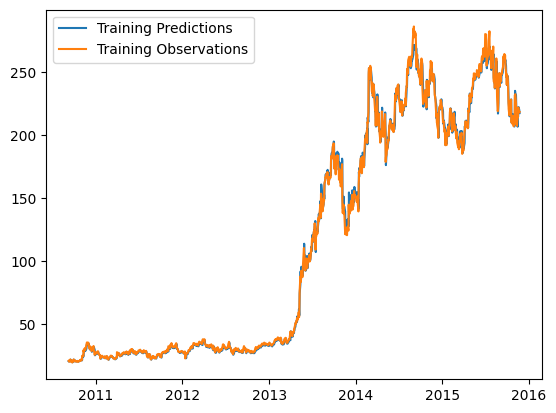

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

8/8 [==============================] - 0s 21ms/step


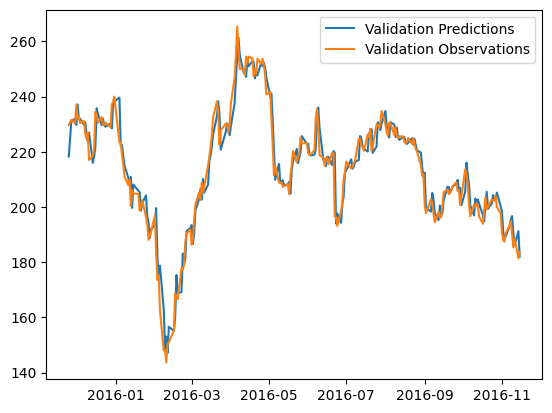

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 12ms/step


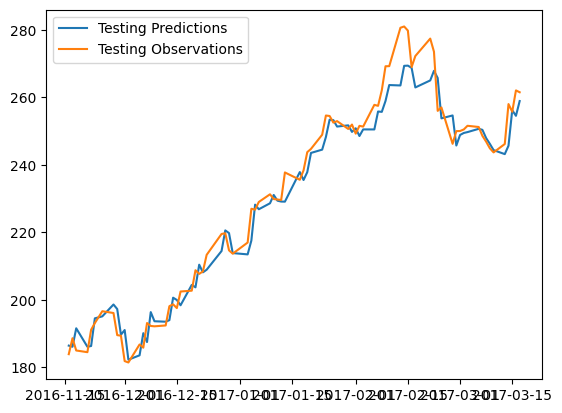

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

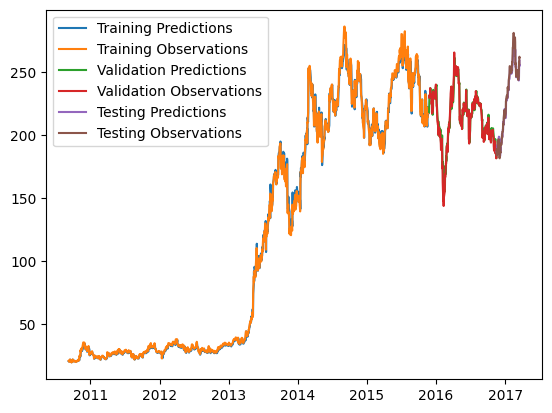

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])